In [1]:
import alias
import alias.injection as inj
import alias.continuum_normalization as cn

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.signal

import numpy as np
from astropy.io import fits

import random as rand

import tqdm.autonotebook as tqdm

plt.rcParams.update({'font.size': 10})

%matplotlib inline

/mnt_home/jhand/alias/alias/injection.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
with open('../data/sample_star_urls', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

/mnt_home/jhand/alias/alias/__init__.py:59: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2
/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


In [3]:
# Injection Testing Framework

def create_laser_signature(wave, lsf, idx):
    line = np.interp(np.array(range(len(wave)))-idx, lsf.x, lsf.y)
    return line

def injection_test(ds, lsf, detector, count, min_amp, max_amp):
    results = []

    for i in tqdm.trange(count):
        
        spec = rand.randrange(len(ds.flux))
        valid_idx = np.nonzero(~np.isnan(ds.flux[spec]))[0]
        idx_int = np.random.choice(valid_idx)
        idx = idx_int + np.random.uniform(-0.5, 0.5)
        wave = np.interp(idx, range(len(ds.wave)), ds.wave)
        amp = np.random.uniform(min_amp, max_amp)

        nflux = np.copy(ds.flux[spec])
        nflux += create_laser_signature(ds.wave, lsf, idx)*amp
        
        detections = detector(ds.wave, nflux, ds.ivar[spec])

        if len(detections) == 0:
            results.append((spec, idx, amp, 0, 0, 0, 0))
            continue

        detection_wavelengths = detections[:,0]
        detection_amplitudes = detections[:,1]

        detec_id = np.argmin(np.abs(detection_wavelengths - wave))
        delta_wave = detection_wavelengths[detec_id] - wave

        if np.abs(delta_wave) > 1:
            results.append((spec, idx, amp, 0, 0, 0, len(detections)))
            continue
        
        delta_flux = detection_amplitudes[detec_id] - amp
        results.append((spec, idx, amp, 1, delta_wave, delta_flux, len(detections) - 1))

    return np.array(results, dtype=float)

In [4]:
norm_flux = cn.continuum_normalize(ds.flux, ds.ivar)[0]

median_flux = np.nanmedian(norm_flux, axis=0)
residuals = norm_flux - median_flux[:,]

In [5]:
with open('candidates.csv', 'r') as f:
    
    candidates = np.array([l.split(',') for l in f.read().splitlines()[1:]], dtype=float)

In [6]:
def get_width(wl, height, wave, residuals):
    wave_idx = int(np.interp(wl, wave, range(len(wave))))

    min = wave_idx-1
    while residuals[min] > height/2:
        min = min-1
    wl_l = np.interp(height/2, residuals[min:min+2], wave[min:min+2])
    
    max = wave_idx+1
    while residuals[max] > height/2:
        max = max+1
    wl_h = np.interp(height/2, np.flip(residuals[max-1:max+1]), np.flip(wave[max-1:max+1]))

    return wl_l,wl_h,wl_h-wl_l

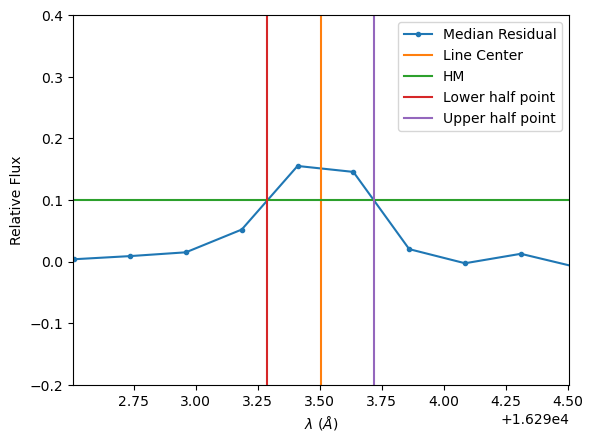

In [11]:

n = 35

wl_l,wl_h,_ = get_width(candidates[n,1], candidates[n,2], ds.wave, norm_flux[int(candidates[n,0])]-median_flux)

plt.plot(ds.wave, norm_flux[int(candidates[n,0])] - median_flux, '.-', label='Median Residual')
plt.plot((candidates[n,1], candidates[n,1]), (-2,2), label='Line Center')

plt.xlim(candidates[n,1] - 1, candidates[n,1] + 1)
plt.ylim(-0.2, 0.4)

plt.plot((14000, 19000), (candidates[n,2]/2, candidates[n,2]/2), label='HM')

plt.plot((wl_l, wl_l), (-2,2), label='Lower half point')
plt.plot((wl_h, wl_h), (-2,2), label='Upper half point')

plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel('Relative Flux')

plt.legend()

In [12]:
widths = np.array([ get_width(candidate[1], candidate[2], ds.wave, norm_flux[int(candidate[0])]-median_flux)[2] for candidate in candidates ])

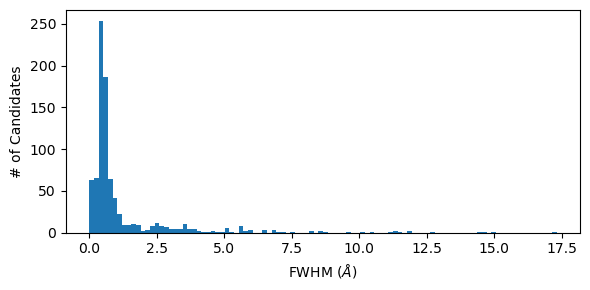

In [13]:
fig, ax = plt.subplots()

ax.hist(widths, bins=100)

ax.set_xlabel(r'FWHM ($\AA$)')
ax.set_ylabel(r'# of Candidates')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

plt.show()

0.6938914873899193


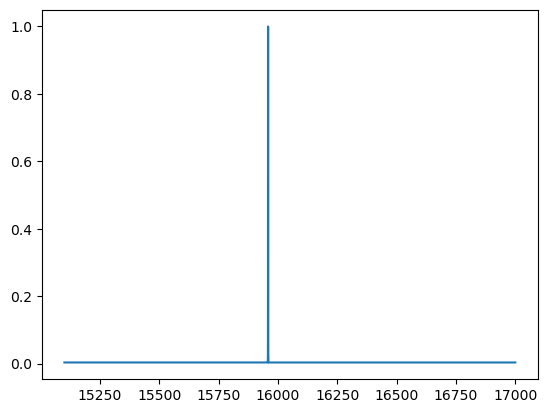

In [14]:
laser_sig = create_laser_signature(ds.wave, inj.default_lsf, 4000)

plt.plot(ds.wave, laser_sig)

lsf_width = get_width(ds.wave[4000], 1, ds.wave, laser_sig)[2]

print(lsf_width)

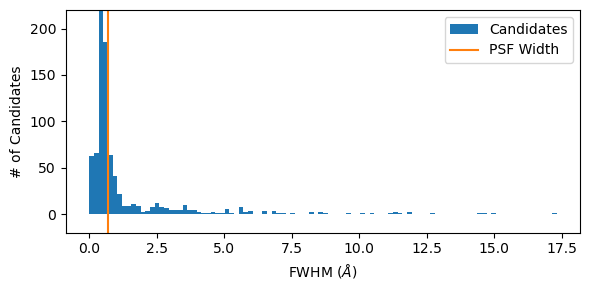

In [15]:
fig, ax = plt.subplots()

ax.hist(widths, bins=100, label='Candidates')
ax.plot((lsf_width,lsf_width), (-100, 300), label='PSF Width')

ax.legend()

ax.set_ylim(-20, 220)

ax.set_xlabel(r'FWHM ($\AA$)')
ax.set_ylabel(r'# of Candidates')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

plt.show()

In [ ]:
#candidates_correct_width = candidates[(widths > 0.6) & (widths < 0.8)]

In [16]:
candidates_wide = candidates[(widths > 0.6)]

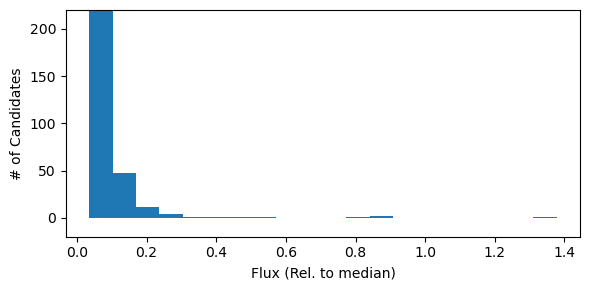

In [17]:
fig, ax = plt.subplots()

ax.hist(candidates_wide[:,2], bins=20, label='Candidates')


ax.set_ylim(-20, 220)

ax.set_xlabel(r'Flux (Rel. to median)')
ax.set_ylabel(r'# of Candidates')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()

plt.show()

In [18]:
np.argwhere((widths > 0.6) & (candidates[:,2] > 0.1))[0]

array([70])

- Create 3x3 plots of candidates wider than PSF
- Put a couple candidates into paper with detailed caption.
- Looking at the epoch spectra

Include identification of the spectrum and distance + other properties (i.e. temperature)

- Add points to fig 11
- Change fig 1 to color-mag and highlight high SNR

In [19]:
subjects = np.argwhere((widths > 0.6) & (candidates[:,2] > 0.1))[0:9]

In [20]:
from astropy.io import fits
from astropy.table import Table

table = Table.read('../data/sample.fits')

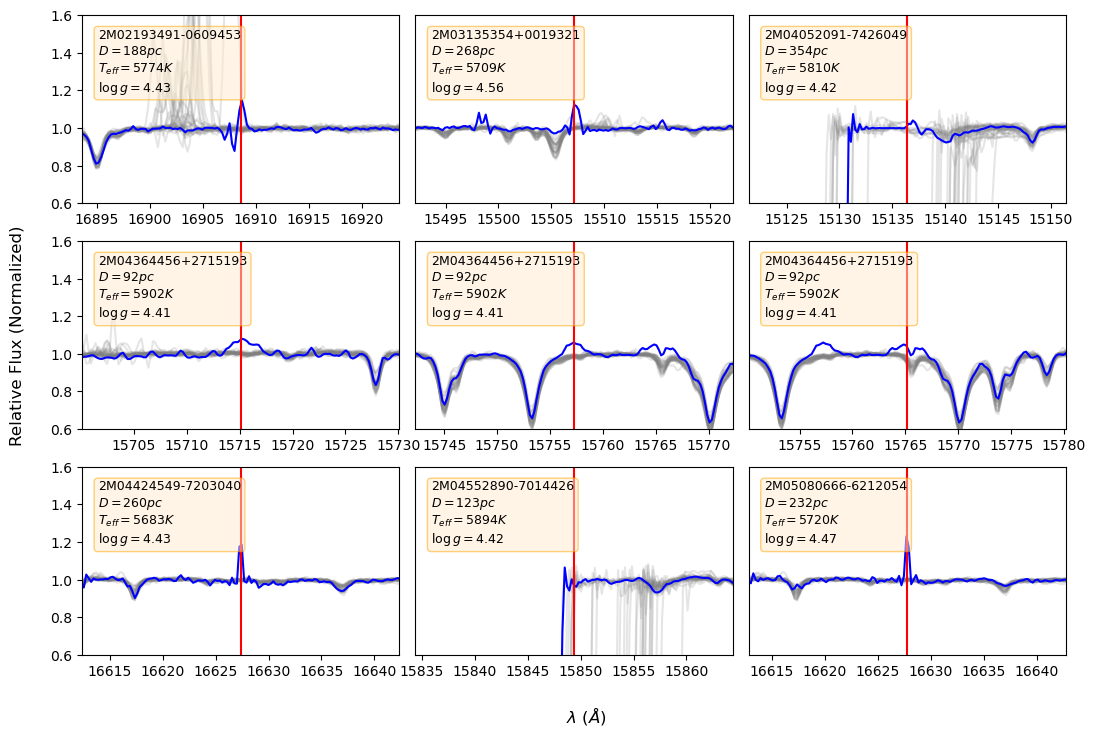

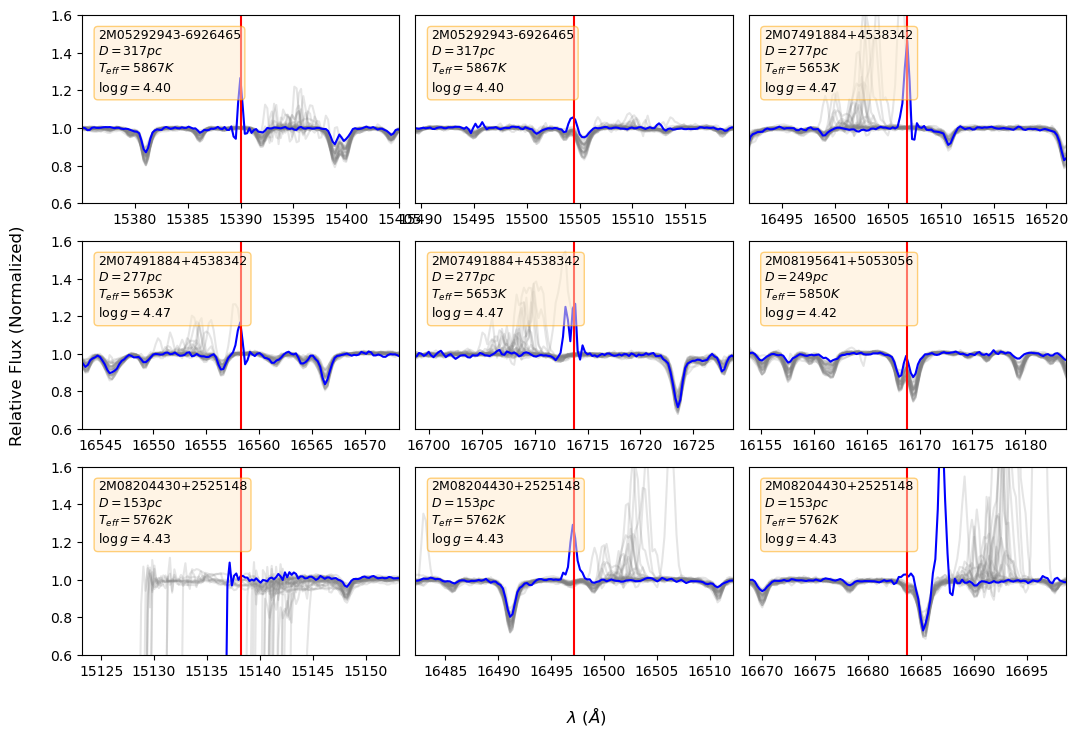

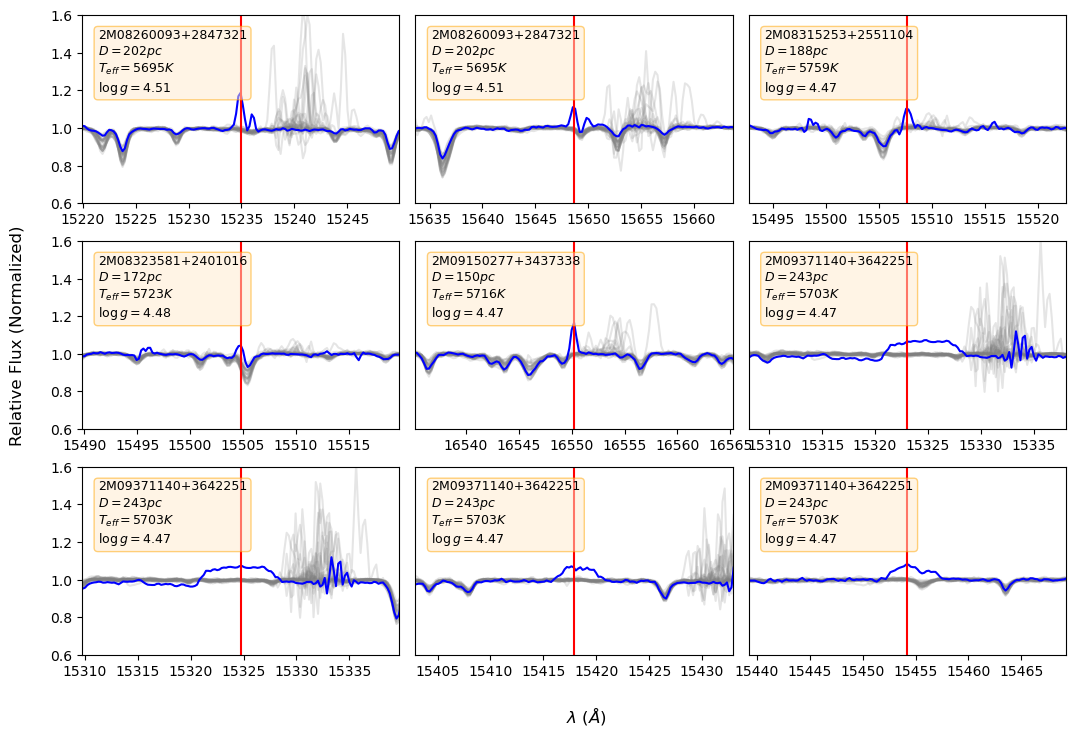

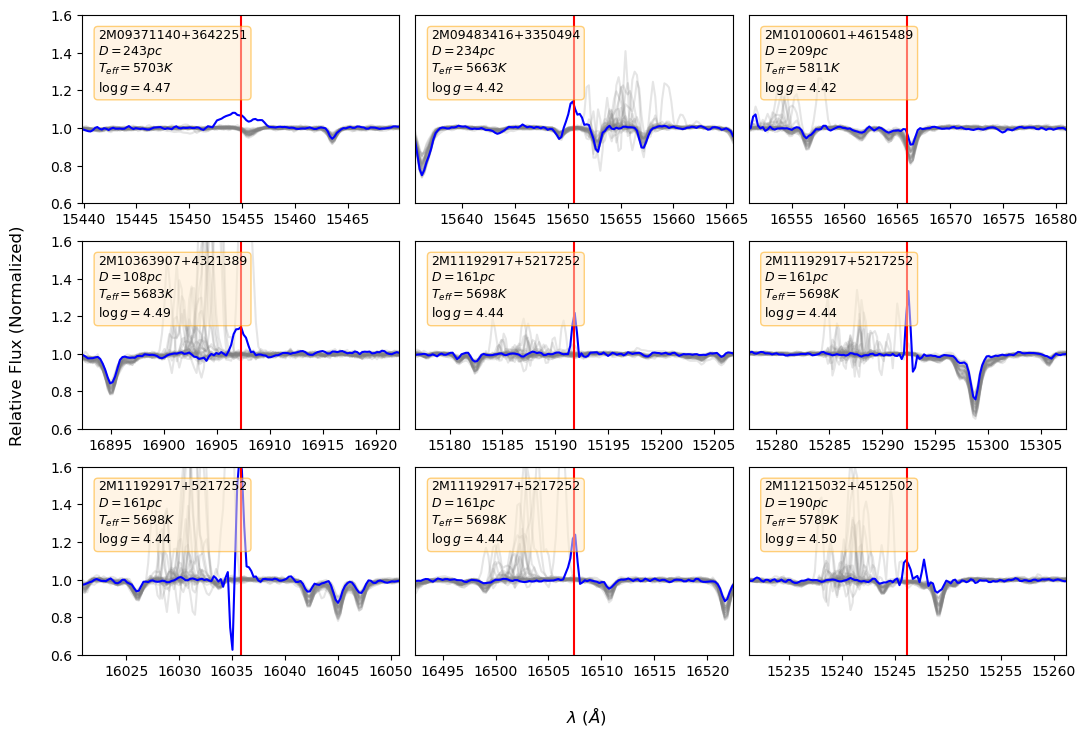

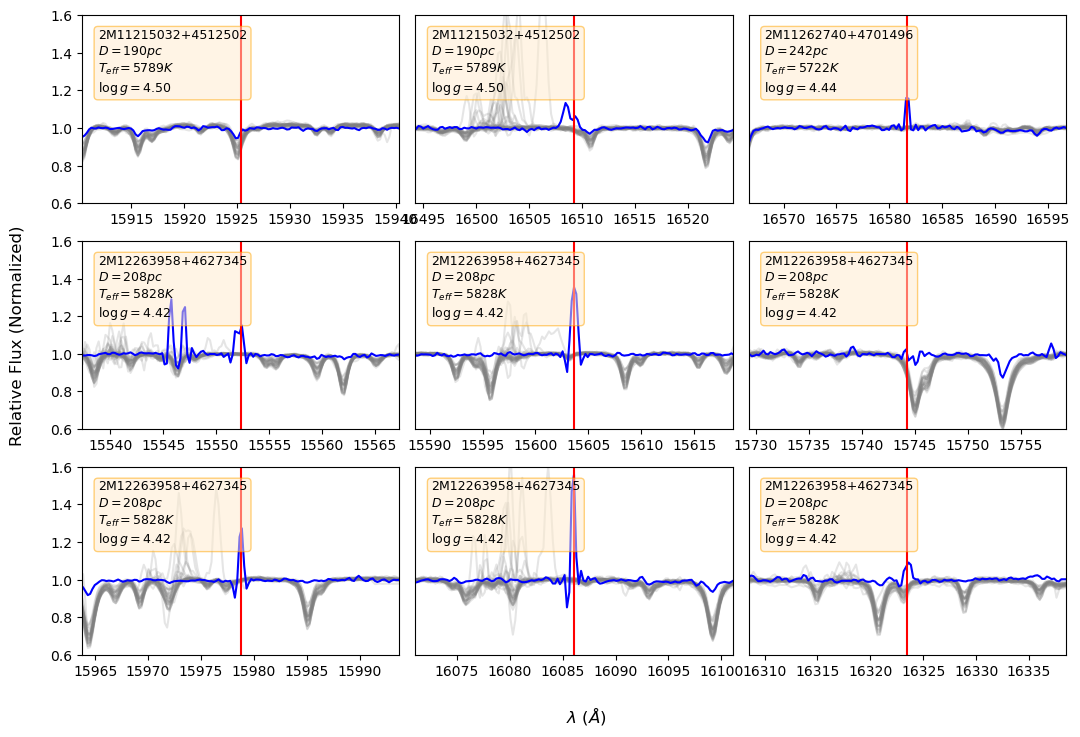

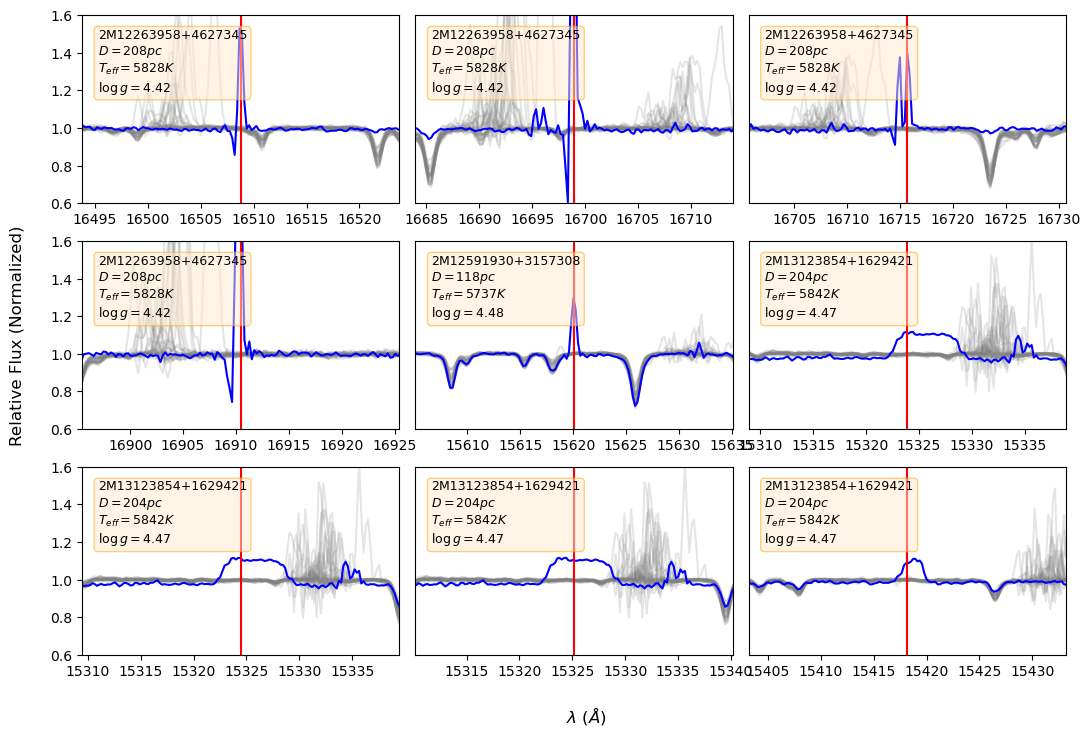

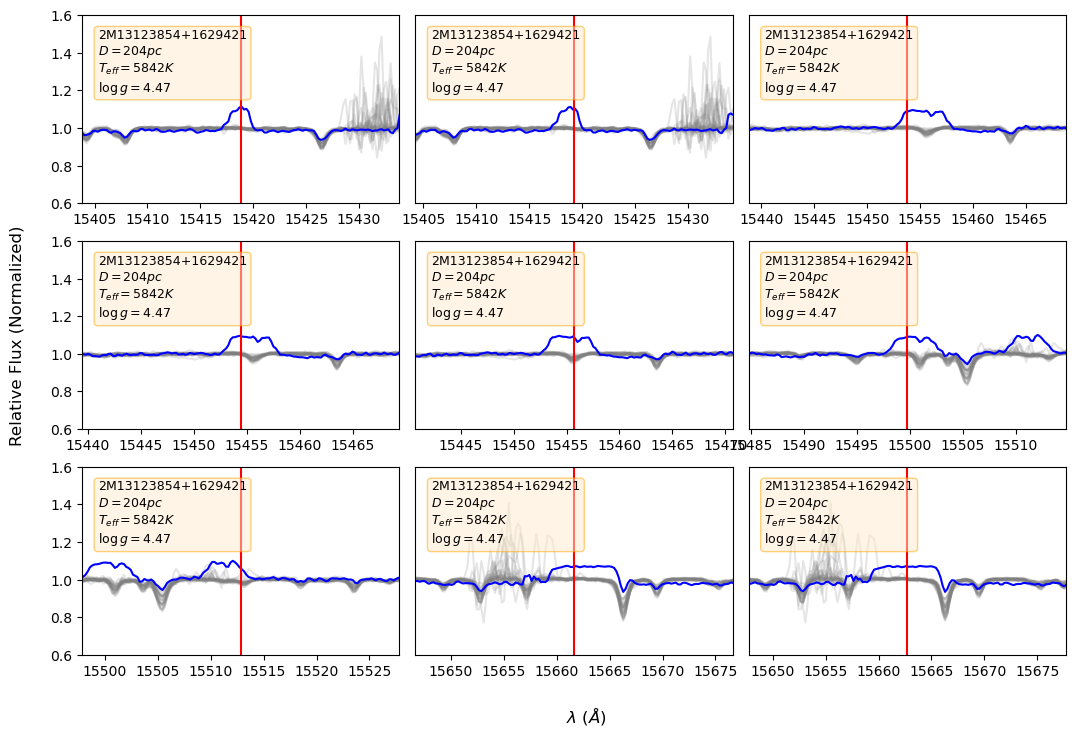

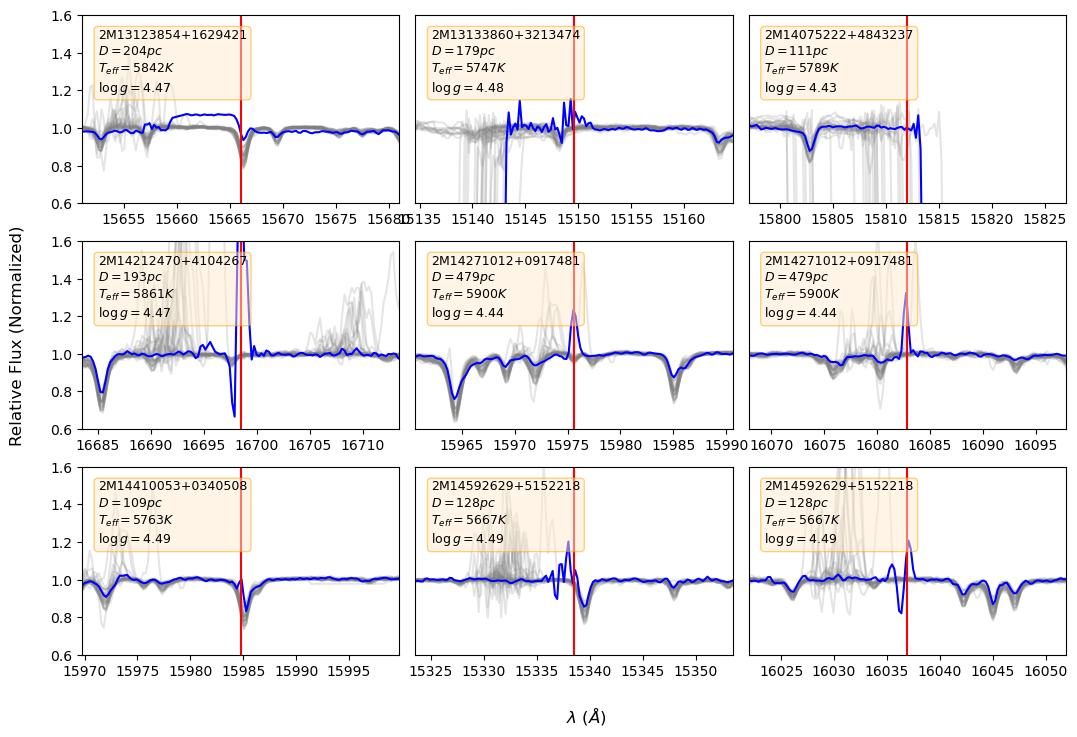

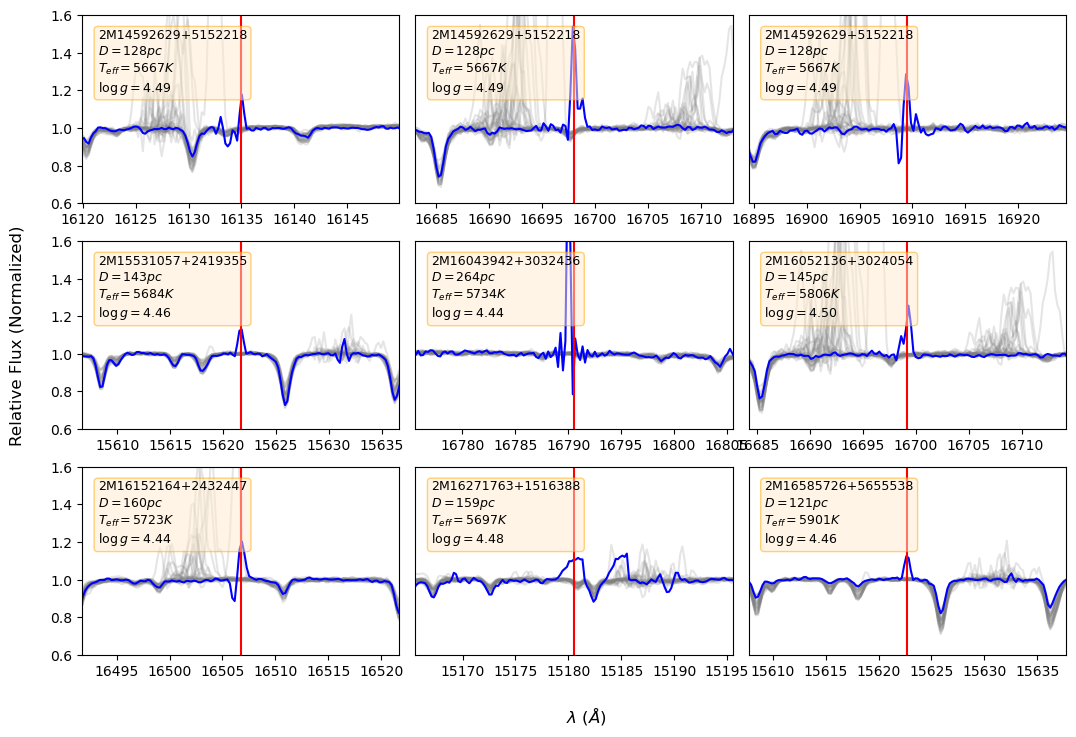

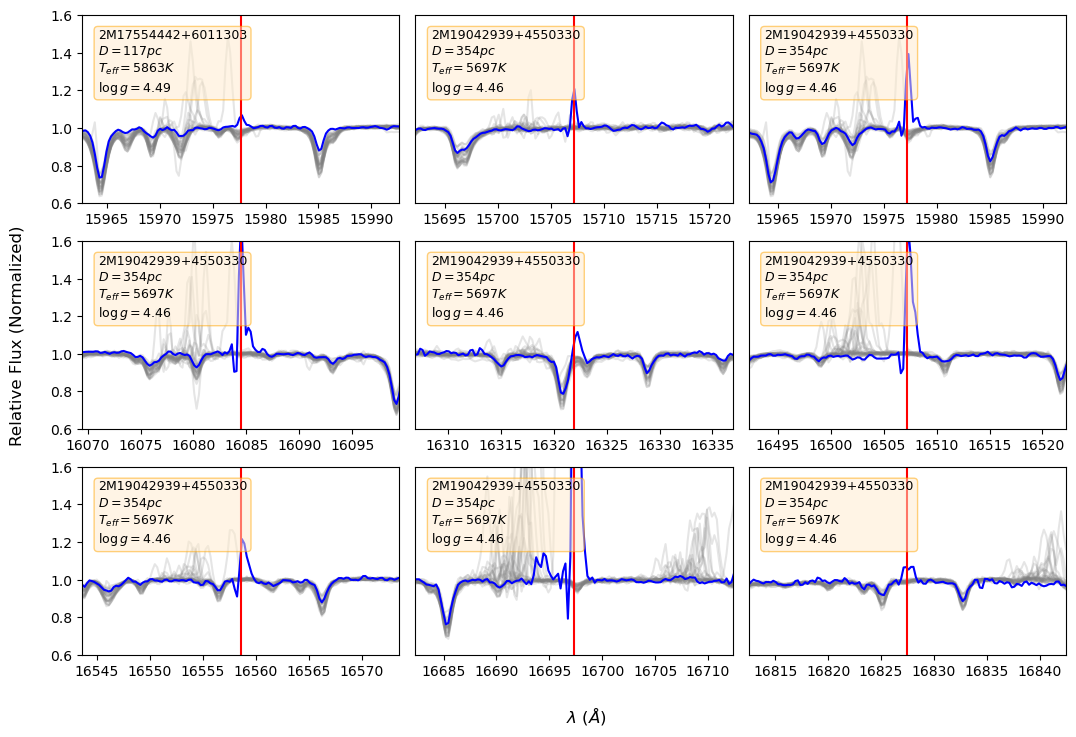

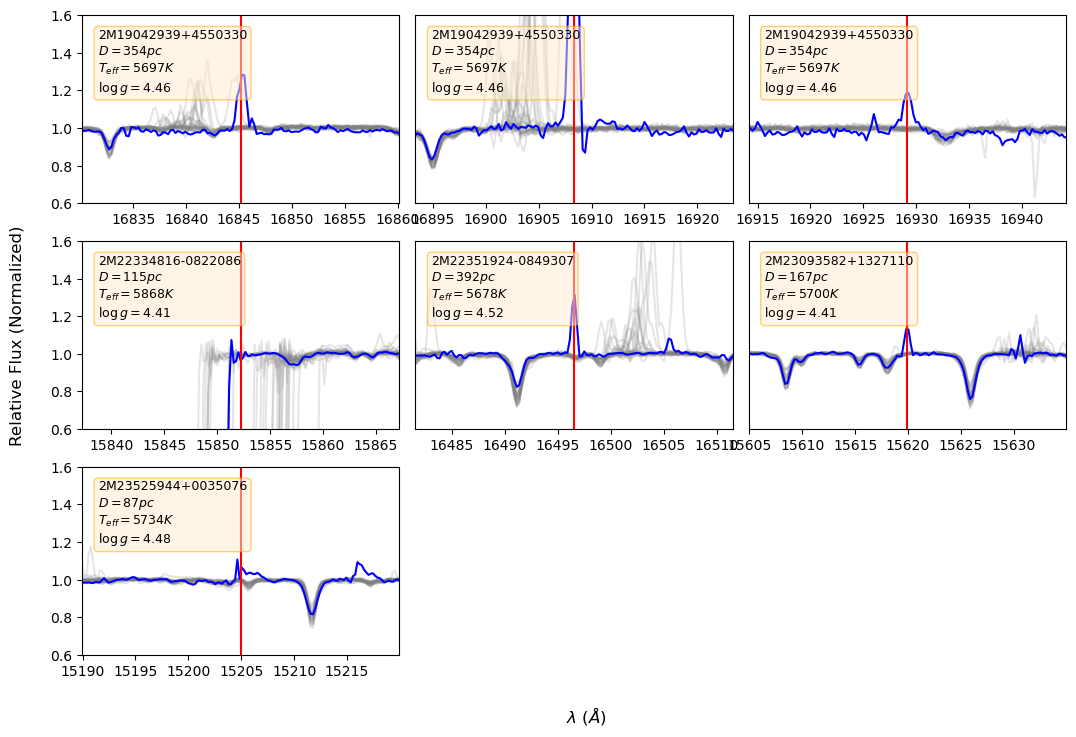

In [21]:
subjects = np.argwhere((widths > 0.5) & (candidates[:,2] > 0.1))

for j in range(0,int(len(subjects)/9 + 1)):

    fig = plt.figure(figsize=(12,8))
    
    gs = gridspec.GridSpec(3, 3, left=0.08, right=0.9, bottom=0.1, top=0.9, wspace=0.05)
    
    for i in range(0,9):
        if i + 9*j >= len(subjects):
            break
        
        ax = fig.add_subplot(gs[int(i/3), i%3])
        n = subjects[i + 9*j][0]
        spec_id = int(candidates[n][0])
        
        ax.plot(ds.wave, norm_flux[0:30].T, alpha=0.2, color='gray')
        ax.plot(ds.wave, norm_flux[int(candidates[n,0])], color='blue')
        ax.plot((candidates[n,1], candidates[n,1]), (0,2), color='red')
        
        ax.set_xlim(candidates[n,1] - 15, candidates[n,1] + 15)
        ax.set_ylim(0.6, 1.6)
        stats = '%s\n$D = %.fpc$\n$T_{eff} = %.fK$\n$\log g = %.2f$' % (table['APOGEE_ID'][spec_id], table['GAIAEDR3_R_LO_PHOTOGEO'][spec_id], table['TEFF'][spec_id], table['LOGG'][spec_id])
        bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
        ax.text(0.05, 0.93, stats, fontsize=9, bbox=bbox,
                transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
        if i%3 > 0:
            ax.set_yticks([])
    
    fig.supxlabel(r'$\lambda$ ($\AA$)')
    fig.supylabel(r'Relative Flux (Normalized)')

    fig.savefig('../data/candidates/sheet_%d.png' % j)

In [ ]:
n=3
str(table['TARGET_ID'][3])

In [ ]:
table.columns

In [ ]:
fig = plt.figure()

gs = gridspec.GridSpec(2, 1, left=0.12, right=0.9, bottom=0.1, top=0.9, wspace=0.05)

ax1 = fig.add_subplot(gs[0])

n = int(subjects[14])
spec_id = int(candidates[n][0])
        
ax1.plot(ds.wave, norm_flux[0:30].T, alpha=0.2, color='gray')
ax1.plot(ds.wave, norm_flux[int(candidates[n,0])], color='blue')
ax1.plot((candidates[n,1], candidates[n,1]), (0,2), color='red')
        
ax1.set_xlim(candidates[n,1] - 15, candidates[n,1] + 15)
ax1.set_ylim(0.6, 1.6)
stats = '%s\n$D = %.fpc$\n$T_{eff} = %.fK$\n$\log g = %.2f$' % (table['APOGEE_ID'][spec_id], table['GAIAEDR3_R_LO_PHOTOGEO'][spec_id], table['TEFF'][spec_id], table['LOGG'][spec_id])
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax1.text(0.03, 0.95, stats, fontsize=9, bbox=bbox,
        transform=ax1.transAxes, horizontalalignment='left', verticalalignment='top')


ax2 = fig.add_subplot(gs[1])

n = int(subjects[17])
spec_id = int(candidates[n][0])
        
ax2.plot(ds.wave, norm_flux[0:30].T, alpha=0.2, color='gray')
ax2.plot(ds.wave, norm_flux[int(candidates[n,0])], color='blue')
ax2.plot((candidates[n,1], candidates[n,1]), (0,2), color='red')
        
ax2.set_xlim(candidates[n,1] - 15, candidates[n,1] + 15)
ax2.set_ylim(0.6, 1.6)
stats = '%s\n$D = %.fpc$\n$T_{eff} = %.fK$\n$\log g = %.2f$' % (table['APOGEE_ID'][spec_id], table['GAIAEDR3_R_LO_PHOTOGEO'][spec_id], table['TEFF'][spec_id], table['LOGG'][spec_id])
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax2.text(0.03, 0.95, stats, fontsize=9, bbox=bbox,
        transform=ax2.transAxes, horizontalalignment='left', verticalalignment='top')
    
fig.supxlabel(r'$\lambda$ ($\AA$)')
fig.supylabel(r'Relative Flux (Normalized)')

fig.set_figwidth(6)
fig.set_figheight(7)


In [ ]:
fig, ax = plt.subplots()

n = int(subjects[18])
spec_id = int(candidates[n][0])
        
ax.plot(ds.wave, norm_flux[0:30].T, alpha=0.2, color='gray')
ax.plot(ds.wave, norm_flux[int(candidates[n,0])], color='blue')
ax.plot((candidates[n,1], candidates[n,1]), (0,2), color='red')
        
ax.set_xlim(candidates[n,1] - 15, candidates[n,1] + 15)
ax.set_ylim(0.6, 1.6)
stats = '%s\n$D = %.fpc$\n$T_{eff} = %.fK$\n$\log g = %.2f$' % (table['APOGEE_ID'][spec_id], table['GAIAEDR3_R_LO_PHOTOGEO'][spec_id], table['TEFF'][spec_id], table['LOGG'][spec_id])
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax.text(0.03, 0.95, stats, fontsize=9, bbox=bbox,
        transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel(r'Relative Flux (Normalized)')

fig.set_figwidth(6)
fig.set_figheight(3)

fig.tight_layout()